# Research question: What is the relationship between the SHAP and feature value?


## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). 

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

In 03d we saw an unexpected high correlation (0.44) between hosptial IVT rate and SHAP value for infarction (even though the SHAP value is small). When looked at main effect instead the correlation was lost. So it seems the correlation came from some leakage of hospital SHAP interactions into the Infarction SHAP value. So far in that notebook (03d) we looked at the two extremes: SHAP values (includes all interactions) and main effect (no ineractions). Since we're splitting the features into two groups (hospital ones, and patient ones) to fit a multiple regressions on, let's only include the SHAP interactions for the features that are in the same regression. So only the main effect and the interactions that are with the other features in the multiple regression. This way we have a bunch of SHAP interactions that are between the hostpial features and patient features. For completeness, fit a multiple regression on these. Do that in this notebook: Get main effect and interactions for features in multiple regression group, for each feature for each patient

In this notebook we used the model from notebook 03a (all data model) and focus on understanding how much of the variation in the hosptials thrombolysis rate can be attributed to the difference in the hospital processes, and to its different patient mix.

we will create a "subgroup SHAP value" for each feature. The 10 features in the model can be classified as either those that are describing the patients characteristics (the “patient descriptive features”) or those that are describing the hospital’s processes (the “hospital descriptive features”). There are eight patient descriptive features (age, stroke severity, prior disability, onset-to-arrival time, stroke type, type of onset time, anticoagulants, and onset during sleep) and there are two hospital descriptive features (arrival-to-scan time, and hospital attended). For this analysis, we only included the single one-hot encoded feature for the attended hospital (and did not include the other 131 one-hot encoded features for the unattended hospitals). We calculated the subgroup SHAP value for each feature by only including the components of it's SHAP value that exclusively contain the effect from the features in the same subgroup. This is expressed as the sum of the main effect and the interaction effects with the other features within it’s subgroup. For the feature “arrival to scan”, which is part of the hospital descriptive subgroup, its refined SHAP value is the main effect plus the interaction with the feature hospital attended. For each of the features in the patient descriptive subgroup, its refined SHAP value is the main effect plus the sum of the interactions with each of the other seven patient descriptive features. For each set of descriptive features (hospital and patient) we fitted a multiple regression to predict the hospitals observed thrombolysis rate from the mean refined SHAP value of each feature for patients attending each hospital (using values from the all data model).


SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). 

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between the SHAP value and feature values for all features (apart from the hospital feature)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

### Extra code to check something for the paper

In notebook 03_xgb_combined_shap_key_features.ipynb we used the training set from the first kfold to plot the feature value vs SHAP for the top 6 influencial features.

Here we use the 'all data model', and look at all features to inform the subgroup analysis (to include all features for that too, rather than the selected 3 features)

## Show the relationship between feature value and SHAP value for all the features

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03e'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X_data = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X_data.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X_data['Stroke team'], prefix = 'team')
X_data = pd.concat([X_data, X_hosp], axis=1)
X_data.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X_data)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X_data)
y_pred_proba = model.predict_proba(X_data)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    print("Run notebook 03a")
    
# Get SHAP values
filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    print("Run notebook 03a")

CPU times: user 504 ms, sys: 1.5 s, total: 2.01 s
Wall time: 198 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

### Read in SHAP interactions from notebook 03b

In [15]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    print("Run notebook 03b_xgb_shap_values_focus_on_ohe_hospitals.ipynb")

CPU times: user 0 ns, sys: 2.35 s, total: 2.35 s
Wall time: 2.35 s


In [16]:
shap_interaction.shape

(88792, 141, 141)

For each patient, remove the SHAP values for the one-hot encoded hosptial features that are not attended (so only have the one-hot encoded hospital attended).

The create five arrays containing a value per feature:
1) SHAP value (sum of row)
2) main effect (diagonal value)
3) SHAP interactions with other features within multiple regression feature set (per feature row, the columns of the other in regression features)
4) SHAP interactions with other features outside multiple regression feature set (per feature row, the columns of the features not in the regression)
5) main effect + SHAP values within: sum array (2) + (3)

### Define the features in each multiple regression

Have two multiple regressions: patient and hosptial

In [17]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

In [18]:
hospital_features = ['Arrival-to-scan time','Stroke team']

Get a list of the column names, and a list of just the one-hot encoded hospital names (will use the data column names to identify the locations for these features within the SHAP values)

In [19]:
col_names = list(X_data.columns)
col_names[:10]

['Arrival-to-scan time',
 'Infarction',
 'Stroke severity',
 'Precise onset time',
 'Prior disability level',
 'Use of AF anticoagulants',
 'Onset-to-arrival time',
 'Onset during sleep',
 'Age',
 'team_AGNOF1041H']

In [20]:
hospitals_ohe = X_data.filter(regex='^team',axis=1).columns
hospitals_ohe[:10]

Index(['team_AGNOF1041H', 'team_AKCGO9726K', 'team_AOBTM3098N',
       'team_APXEE8191H', 'team_ATDID5461S', 'team_BBXPQ0212O',
       'team_BICAW1125K', 'team_BQZGT7491V', 'team_BXXZS5063A',
       'team_CNBGF2713O'],
      dtype='object')

For each patient calculate 5 different versions of the SHAP value (store each version in it's own dataframe, to be used later to calculate the mean value per hosptial for each value type).

We the create subgroups of features based on whether they describe the 1) patient, or 2) hospital.

The five versions of the SHAP value:
##### 1) SHAP values without any information on hospital attended
Remove the main effect and interactions with the one-hot encoded features for the hosptial not attended. For each patient, identify the hosptial they attended, keep the SHAP for that one-hot encoded feature and remove the other 131.
Note: We will use this as the basis for the other versions of the SHAP value.
##### 2) Main effect value for each of the features
Using the SHAP data without unattended hospital contributions.
We will refer to these as "p_main" (for a patient feature) and "h_main" (for a hospital feature)
##### 3) SHAP interactions with another feature in it's subgroup (patient or hospital)
Using the SHAP data without unattended hospital contributions.
We will refer to these as "p_interactions" (for a patient feature) and "h_interactions" (for a hospital feature)
##### 4) SHAP interactions with a feature in the other subgroup
Using the SHAP data without unattended hospital contributions.
We will refer to these as "hpph_interaction"
##### 5) main effect + SHAP interaction with another feature in it's subgroup
This is the sum of array #2 + #3 
We will refer to these are "p_main_interactions" and "h_main_interactions".

In [21]:
%%time

# get indices for the hospitals
hospitals_indices = [col_names.index(h) for h in hospitals_ohe]

# create list (one per value type) with features as column title
shap_values_without_unattended_hosp = []
shap_main_effects = []
shap_interactions_within_subgroup = []
shap_interactions_across_subgroups = []
shap_main_effects_and_within_interactions = []

# work through each patients shap interaction matrix
for p in range(shap_interaction.shape[0]):

    # get shap interactions for a patient
    si = shap_interaction[p]

    # get hospital the patient attends
    attend = data["Stroke team"].loc[p]
    
    # get column index for hosptial attend
    hospital_keep_index = [col_names.index(f'team_{attend}')]

    # get indices for the other hosptials (those not attend) to remove for 
    #   this patient
    hospitals_remove_indices = list(set(hospitals_indices) - 
                                    set(hospital_keep_index))
    
    # delete the rows and columns in the shap interaction matrix for the 
    #   hospitals not attended
    shap_interaction_attendhosp = np.delete(si, hospitals_remove_indices, 0)
    shap_interaction_attendhosp = np.delete(shap_interaction_attendhosp, 
                                            hospitals_remove_indices, 1)

    # and remove the not attended hospitals from the column names
    col_names_attendhosp = np.delete(col_names, hospitals_remove_indices, 0)

    # rename the one hosptial left with the generic "Stroke team" name
    col_names_attendhosp = np.char.replace(col_names_attendhosp, 
                                           f'team_{attend}', "Stroke team")
    
    # number of features in the resulting shap interaction matrix
    n_si_features = shap_interaction_attendhosp.shape[0]

    # get the indices for the features in each multiple regression
    patient_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                               for f in patient_features]
    hospital_features_col_id = [np.where(col_names_attendhosp==f)[0][0] 
                                for f in hospital_features]
    
    # calculate the different feature values
    # 1. SHAP values (without any contribution from hospital not attended)
    shap_values = shap_interaction_attendhosp.sum(axis=1)

    # add to list (entry per patient containing value per feature)
    shap_values_without_unattended_hosp.append(shap_values)

    # 2. main effect value for each of the features
    main_effects = np.diagonal(shap_interaction_attendhosp)

    # add to list (entry per patient contianing value per feature)
    shap_main_effects.append(main_effects)
    
    # 3. SHAP interactions within feature subgroup (patient, hospital)
    list_of_list = [patient_features_col_id,
                    hospital_features_col_id]

    # initialise a zero array with size of number of features (excluding 
    #   unattended hostpial)
    within_subgroup_array = np.zeros((n_si_features))
    # Through a list of subgroup features at a time
    for features_col_ids in list_of_list: 
        # Through features in subgroup
        for f1 in features_col_ids:
            # Take a deep copy of all of the features
            remaining = copy.deepcopy(features_col_ids)
            # Remove the current feature (get a list of the other features in 
            #   the subgroup
            remaining.remove(f1)
            # Initialise a variable to sum the interactions that are with
            #   features from the same subgroup
            sum_elements = 0
            # Through the other features in the subgroup
            for f2 in remaining:
                sum_elements += shap_interaction_attendhosp[f1, f2]
            # Store summed interactions in the array
            within_subgroup_array[f1] = sum_elements
    
    # add to list (entry per patient contianing value per feature)
    shap_interactions_within_subgroup.append(within_subgroup_array)
    
    # 4. SHAP interactions outside feature subgroup
    across_subgroups_array = np.zeros((n_si_features))

    # Through patient subgroup features
    for f1 in patient_features_col_id:
        # Initialise variable to sum the interactions that are with
        #   features from the different subgroup
        sum_elements = 0
        # Through the features in the other subgroup
        for f2 in hospital_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        # Store summed interactions in the array
        across_subgroups_array[f1] = sum_elements

    # Through patient subgroup features
    for f1 in hospital_features_col_id:
        # Initialise variable to sum the interactions that are with
        #   features from the different subgroup
        sum_elements = 0
        # Through the features in the other subgroup
        for f2 in patient_features_col_id:
            sum_elements += shap_interaction_attendhosp[f1, f2]
        # Store summed interactions in the array
        across_subgroups_array[f1] = sum_elements

    # add to list (entry per patient contianing value per feature)
    shap_interactions_across_subgroups.append(across_subgroups_array)

    # 5. main effect + SHAP interaction within: sum array (2) + (3)
    main_effect_and_within = main_effects + within_subgroup_array
    
    # add to list (entry per patient contianing value per feature)
    shap_main_effects_and_within_interactions.append(main_effect_and_within)
    
# put lists into dataframe, with features as column title
df_hosp_shap_values_without_unattended_hosp = (
                        pd.DataFrame(shap_values_without_unattended_hosp, 
                                     columns=col_names_attendhosp))
df_hosp_shap_main_effects = (
                        pd.DataFrame(shap_main_effects, 
                                     columns=col_names_attendhosp))
df_hosp_shap_interactions_within = (
                        pd.DataFrame(shap_interactions_within_subgroup, 
                                     columns=col_names_attendhosp))
df_hosp_shap_interactions_outside = (
                        pd.DataFrame(shap_interactions_across_subgroups, 
                                     columns=col_names_attendhosp))
df_hosp_shap_main_effects_and_within_interactions = (
                        pd.DataFrame(shap_main_effects_and_within_interactions, 
                                     columns=col_names_attendhosp))

CPU times: user 33.3 s, sys: 245 ms, total: 33.5 s
Wall time: 33.4 s


Check SHAP values from explainer, and SHAP values without unattended hospital have very small differences (those that make up the values for hospitals not attended)

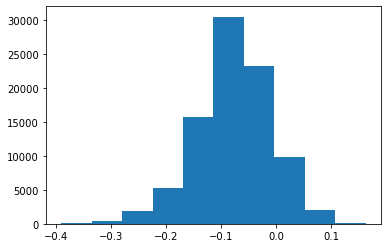

In [22]:
sv_explainer = shap_values_extended.values.sum(axis=1)
sv_without_unattended = df_hosp_shap_values_without_unattended_hosp.sum(axis=1)
sv_difference = sv_explainer - sv_without_unattended
plt.hist(sv_difference);

In [23]:
print(f"By not including the unattended hospitals in the SHAP values, we are "
      f"missing between {np.exp(sv_difference.min())} and "
      f"{np.exp(sv_difference.max())} fold difference in odds")

By not including the unattended hospitals in the SHAP values, we are missing between 0.6763344986171859 and 1.1762849740812618 fold difference in odds


In [24]:
np.exp(sv_difference.mean())

0.9259630628879226

### Calculate the mean value for the patients that attend each hospital

Get set of hosptial names

In [25]:
unique_stroketeams_list = list(set(data["Stroke team"]))

For each version of the SHAP values, use function to return the mean per set of patients that attend each hospital

In [26]:
# Add the team attended to each patient, then groupby the stroke team and 
#   calculate mean of all features for patients attending each hospital
temp_df = df_hosp_shap_values_without_unattended_hosp.join(data["Stroke team"], 
                                                           rsuffix=' attended')
df_hosp_mean_shap_values_without_unattended_hosp = (
                                temp_df.groupby("Stroke team attended").mean())

In [27]:
# Add the team attended to each patient, then groupby the stroke team and 
#   calculate mean of all features for patients attending each hospital
temp_df = df_hosp_shap_main_effects.join(data["Stroke team"], 
                                         rsuffix=' attended')
df_hosp_mean_shap_main = (temp_df.groupby("Stroke team attended").mean())

In [28]:
# Add the team attended to each patient, then groupby the stroke team and 
#   calculate mean of all features for patients attending each hospital
temp_df = df_hosp_shap_interactions_within.join(data["Stroke team"], 
                                                rsuffix=' attended')
df_hosp_mean_shap_interactions_within = (
                                temp_df.groupby("Stroke team attended").mean())

In [29]:
# Add the team attended to each patient, then groupby the stroke team and 
#   calculate mean of all features for patients attending each hospital
temp_df = df_hosp_shap_interactions_outside.join(data["Stroke team"], 
                                                 rsuffix=' attended')
df_hosp_mean_shap_interactions_outside = (
                                temp_df.groupby("Stroke team attended").mean())

In [30]:
# Add the team attended to each patient, then groupby the stroke team and 
#   calculate mean of all features for patients attending each hospital
temp_df = df_hosp_shap_main_effects_and_within_interactions.join(
                                                        data["Stroke team"], 
                                                        rsuffix=' attended')
df_hosp_mean_shap_main_effects_and_within_interactions = (
                                temp_df.groupby("Stroke team attended").mean())

Add thrombolysis rate to each dataframe

In [31]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [32]:
df_hosp_mean_shap_values_without_unattended_hosp = (
        df_hosp_mean_shap_values_without_unattended_hosp.join(hosp_ivt_rate))
df_hosp_mean_shap_main = (
        df_hosp_mean_shap_main.join(hosp_ivt_rate))
df_hosp_mean_shap_interactions_within = (
        df_hosp_mean_shap_interactions_within.join(hosp_ivt_rate))
df_hosp_mean_shap_interactions_outside = (
        df_hosp_mean_shap_interactions_outside.join(hosp_ivt_rate))
df_hosp_mean_shap_main_effects_and_within_interactions = (
        df_hosp_mean_shap_main_effects_and_within_interactions.join(hosp_ivt_rate))

In [33]:
def plot_regressions(df_hosp_mean, features, title):
    n_features = len(features)
    cols = 3
    rows = np.int((n_features / cols) + 1)
    count = 1

    fig = plt.figure(figsize=((6*cols),(6*rows)))
    
    for feat in features: 
        # Setup data for chart
        x = df_hosp_mean[feat]
        y = df_hosp_mean['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
#        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(rows,cols,count)
#        ax = fig.add_subplot(1,1,1)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{title} {feat} "
                      f"\n(mean of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

        (xmin, xmax) = ax.get_xlim()
        (ymin, ymax) = ax.get_ylim()

        plt.grid()

        # Add  text
        f = (str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

    
        x_placement = xmin + 0.05*(xmax - xmin)
        y_placement = ymax - 0.15*(ymax - ymin)
        ax.text(x_placement, y_placement, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

        count+=1
    # Save figure

    #    plt.savefig(f'./output/{notebook}_{model_text}'
    #                f'_attended_hosp_shap_value.jpg', 
    #                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    return()

### Function to fit and plot a multiple regression on a set of features vs IVT rate

In [34]:
def fit_and_plot_multiple_regression(df_hosp_mean, features, x_label_text="", 
                                     ax=None):
    X = df_hosp_mean[features]
    y = df_hosp_mean['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, 
                                columns=["coeff"])
    print(df_reg_coeff)

    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred_line = intercept + (y * slope)
    
    # Create scatter plot with regression line
    if ax is None: 
        ax = plt.gca()
    
#    fig = plt.figure(figsize=(6,6))
#    ax = fig.add_subplot(1,1,1)

    ax.scatter(y_pred, y, color = 'k', marker="o", s=20)
    ax.plot (y_pred_line, y, color = 'k', linestyle='--', linewidth=1)

    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()
    axis_min = min(xmin, ymin)
    axis_max = max(xmax, ymax)
    
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_xlabel(f'Hospital thrombolysis rate (predicted{x_label_text})')
    ax.set_ylabel('Hospital thrombolysis rate (observed)')

    plt.grid()

    # Add  text
    f = (str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    
    x_placement = axis_min + 0.05*(axis_max - axis_min)
    y_placement = axis_max - 0.15*(axis_max - axis_min)
    ax.text(x_placement, y_placement, text,
             bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure
#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
#    plt.show()
    return(ax)

Regression between hosptial IVT rate and it's patients mean patient feature value


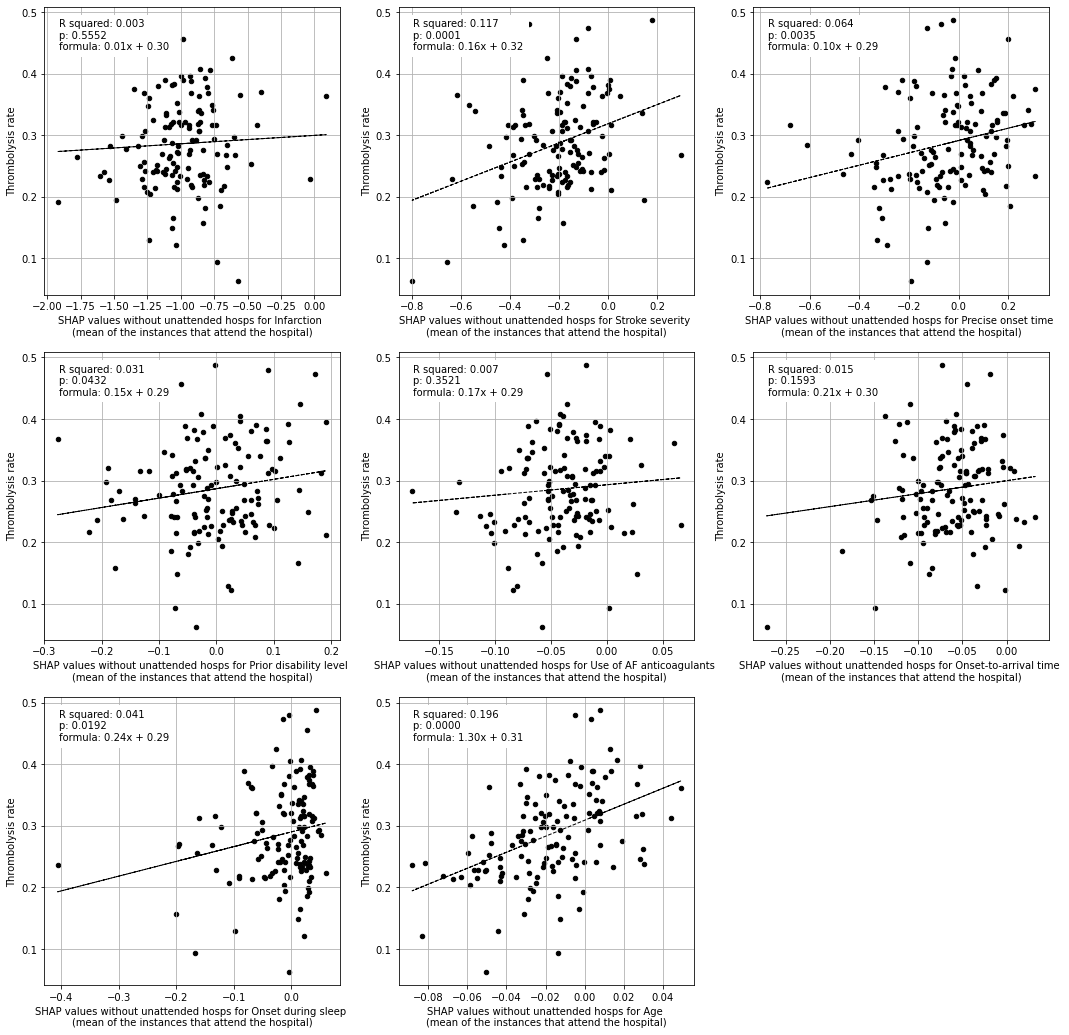


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction                0.040841
Stroke severity           0.138831
Precise onset time        0.057969
Prior disability level    0.046839
Use of AF anticoagulants -0.057981
Onset-to-arrival time     0.055069
Onset during sleep        0.120940
Age                       1.053469


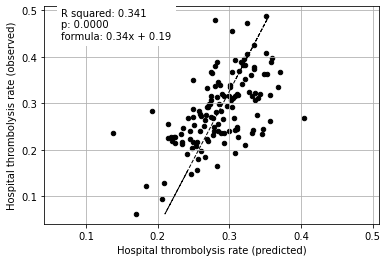


Regression between hosptial IVT rate and it's patients mean hospital feature value


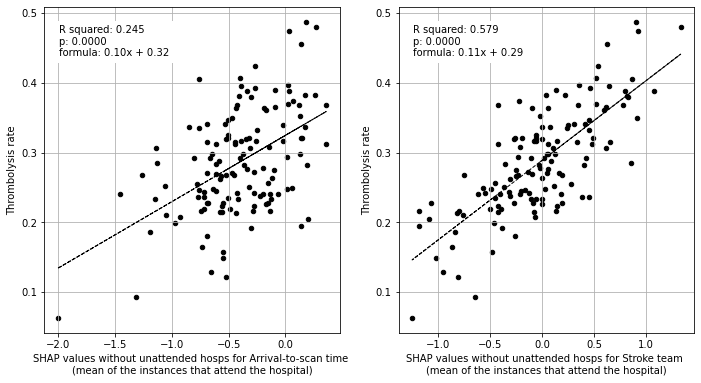


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                         coeff
Arrival-to-scan time  0.080042
Stroke team           0.107340


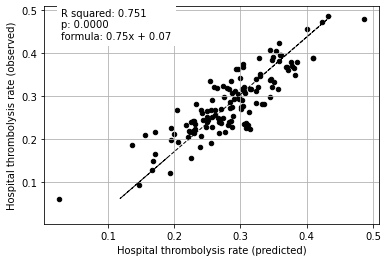

In [35]:
title = "SHAP values without unattended hosps for"
df = df_hosp_mean_shap_values_without_unattended_hosp

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)
plt.show()
print ()

print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
plt.show()

Regression between hosptial IVT rate and it's patients mean patient feature value


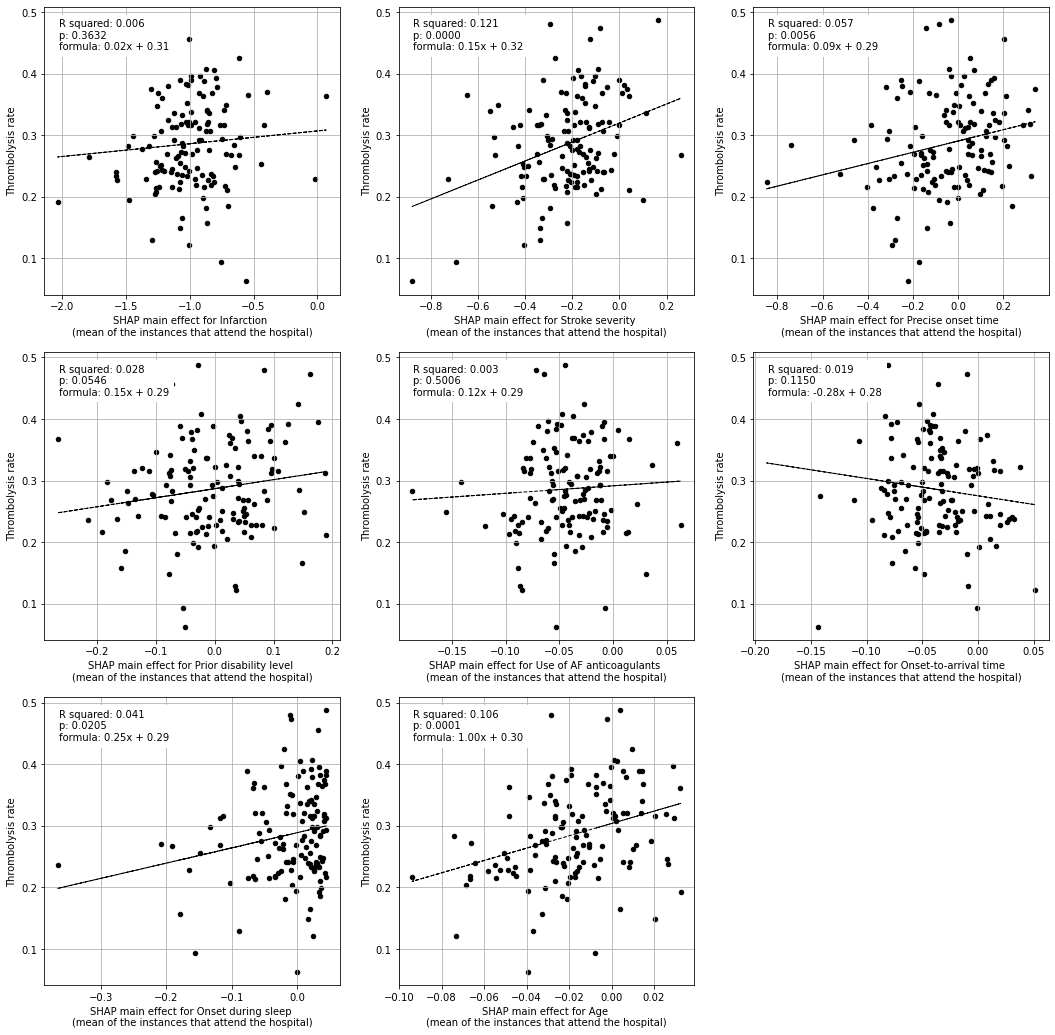


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction                0.044203
Stroke severity           0.161030
Precise onset time        0.052356
Prior disability level    0.041763
Use of AF anticoagulants  0.004634
Onset-to-arrival time    -0.332927
Onset during sleep        0.216030
Age                       0.793499


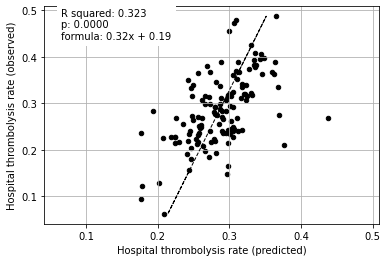


Regression between hosptial IVT rate and it's patients mean hospital feature value


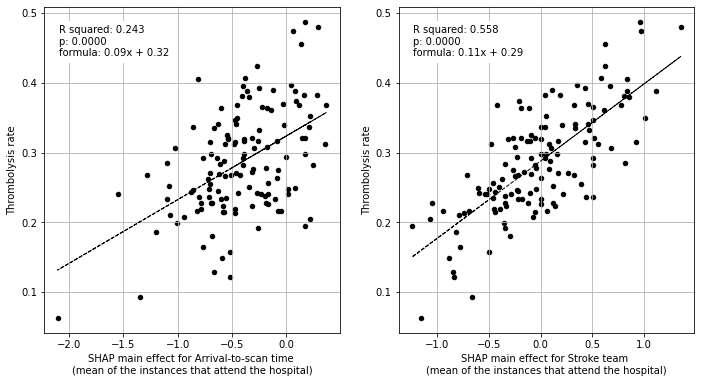


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                         coeff
Arrival-to-scan time  0.078443
Stroke team           0.104766


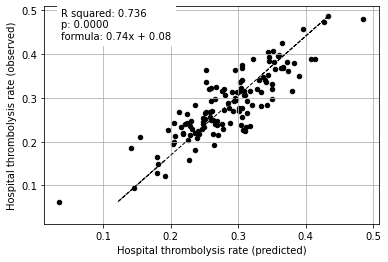

In [36]:
title = "SHAP main effect for"
df = df_hosp_mean_shap_main

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)
plt.show()
print ()

print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
plt.show()

Regression between hosptial IVT rate and it's patients mean patient feature value


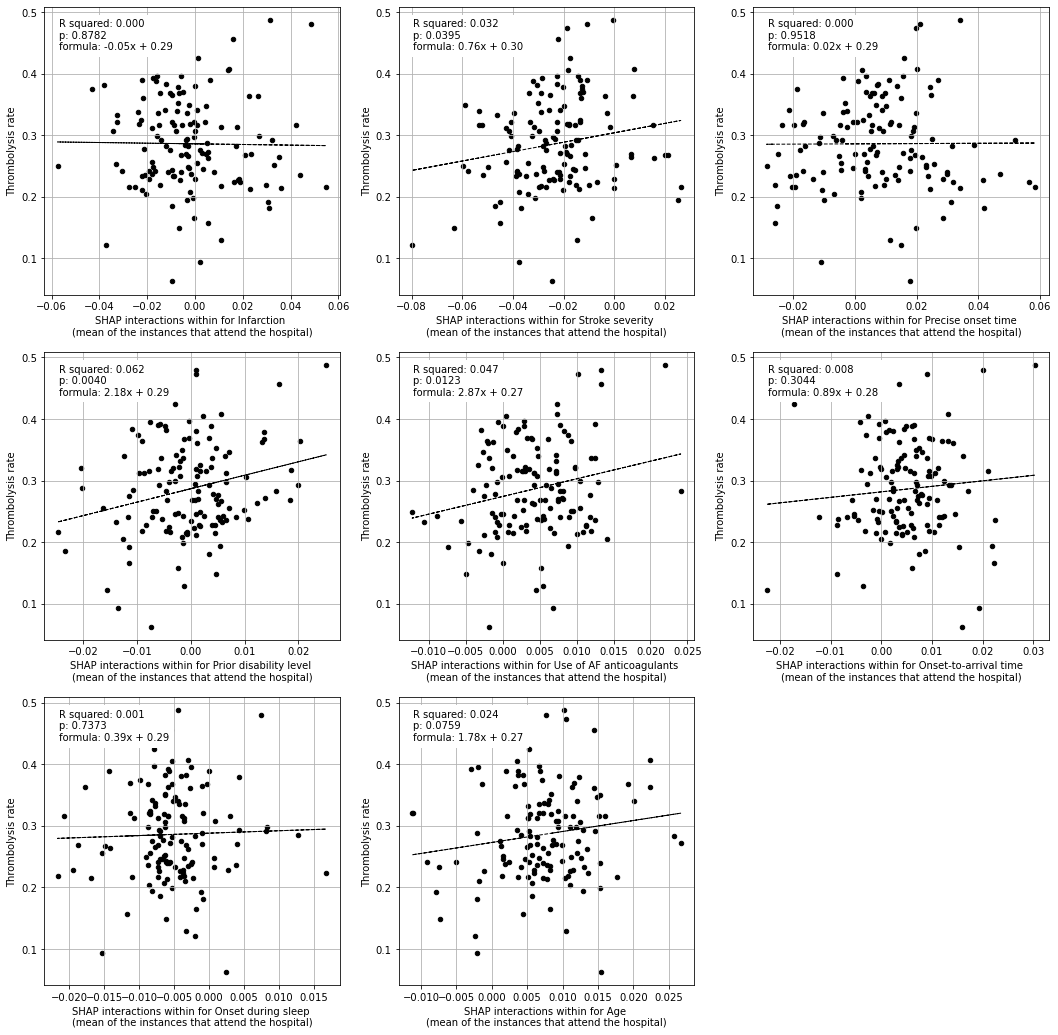


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction               -0.857990
Stroke severity           0.876208
Precise onset time       -0.373399
Prior disability level    1.872548
Use of AF anticoagulants  2.636026
Onset-to-arrival time     0.489986
Onset during sleep        1.599541
Age                       0.020306


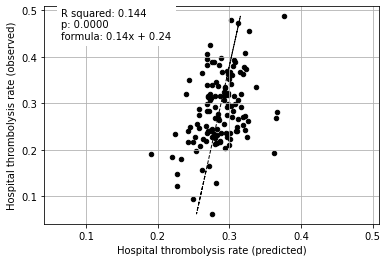


Regression between hosptial IVT rate and it's patients mean hospital feature value


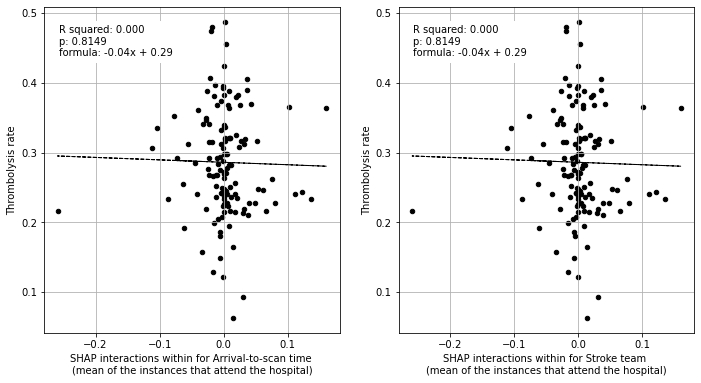


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                              coeff
Arrival-to-scan time -311138.315711
Stroke team           311138.273753


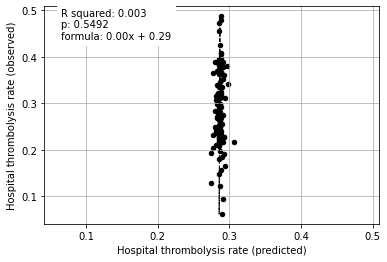

In [37]:
title = "SHAP interactions within for"
df = df_hosp_mean_shap_interactions_within

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)
plt.show()
print ()

print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
plt.show()

Regression between hosptial IVT rate and it's patients mean patient feature value


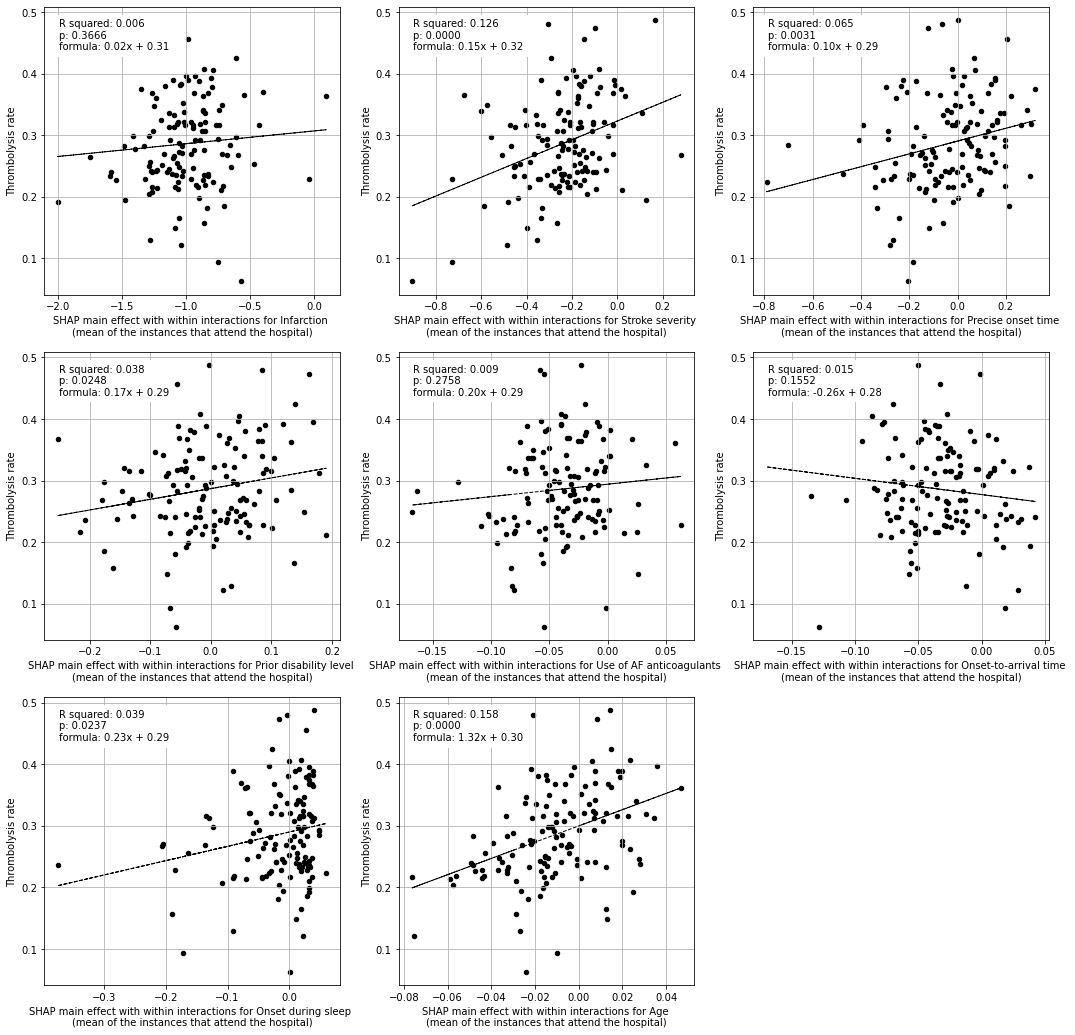


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction                0.041541
Stroke severity           0.149400
Precise onset time        0.065744
Prior disability level    0.047780
Use of AF anticoagulants  0.032430
Onset-to-arrival time    -0.275901
Onset during sleep        0.181704
Age                       1.033392


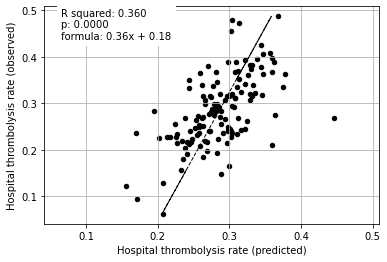


Regression between hosptial IVT rate and it's patients mean hospital feature value


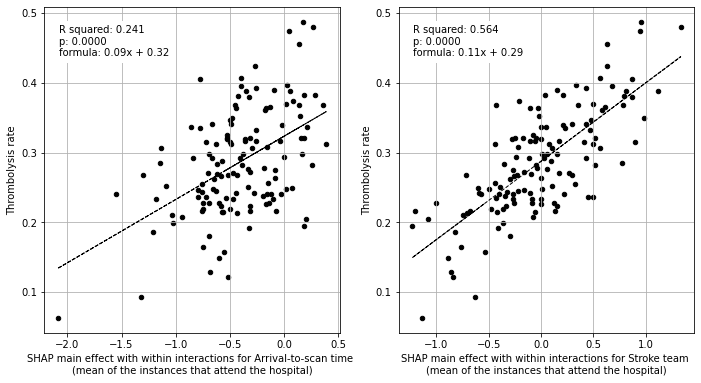


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                         coeff
Arrival-to-scan time  0.078743
Stroke team           0.106717


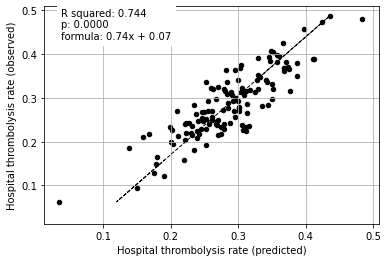

In [38]:
title = "SHAP main effect with within interactions for"
df = df_hosp_mean_shap_main_effects_and_within_interactions

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)
plt.show()
print ()

print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
plt.show()

Regression between hosptial IVT rate and it's patients mean patient feature value


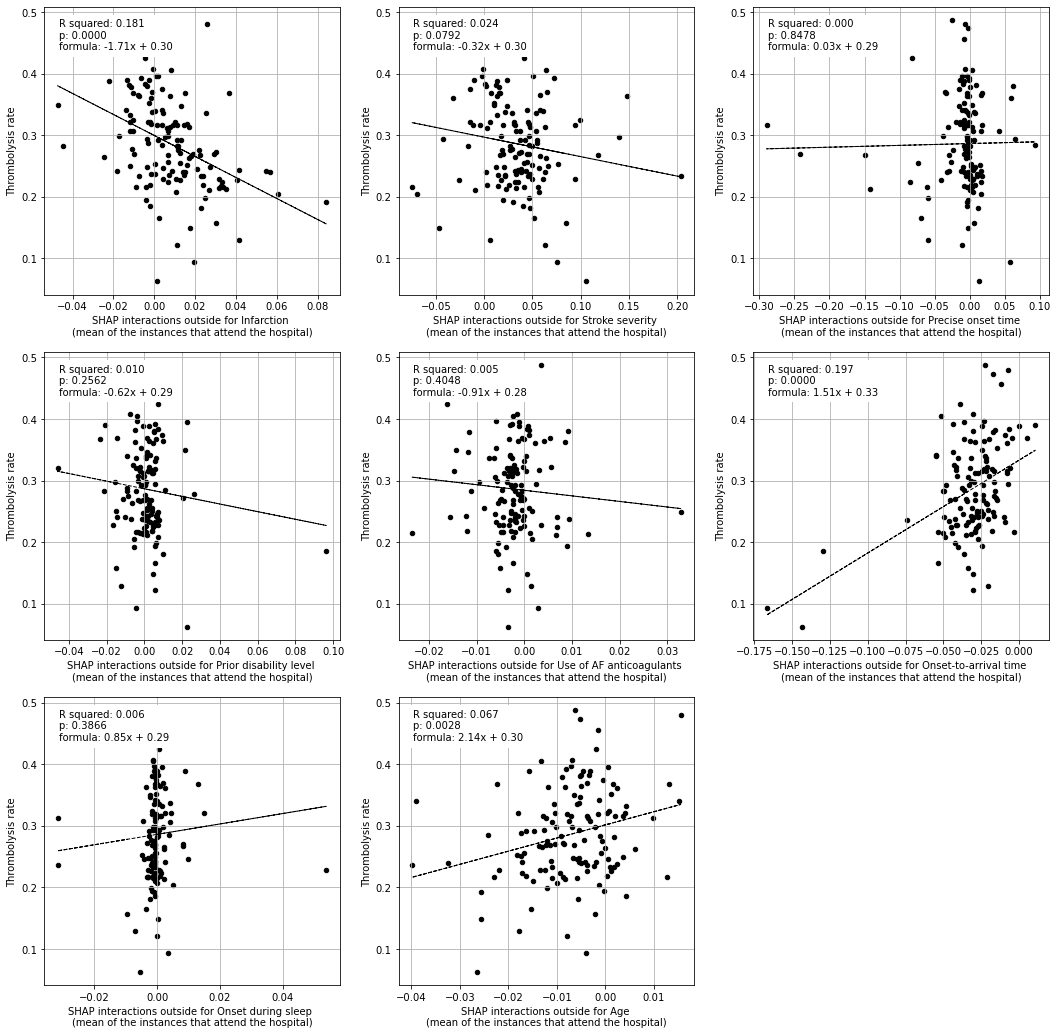


Multiple regression between hosptial IVT rate and it's patients mean patient feature values
                             coeff
Infarction               -1.518389
Stroke severity          -0.107786
Precise onset time        0.026807
Prior disability level    0.088766
Use of AF anticoagulants -1.447954
Onset-to-arrival time     1.304490
Onset during sleep        0.118613
Age                       0.548842


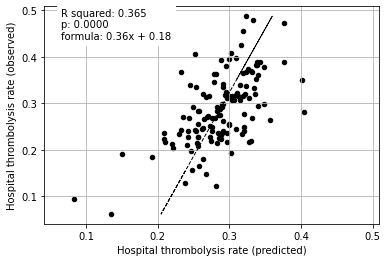


Regression between hosptial IVT rate and it's patients mean hospital feature value


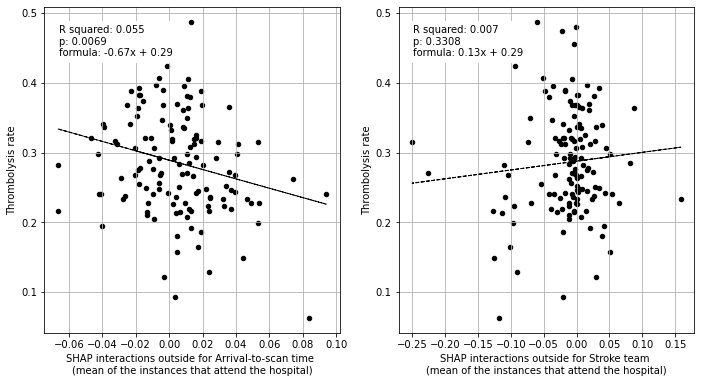


Multiple regression between hosptial IVT rate and it's patients mean hospital feature values
                         coeff
Arrival-to-scan time -0.648343
Stroke team           0.062870


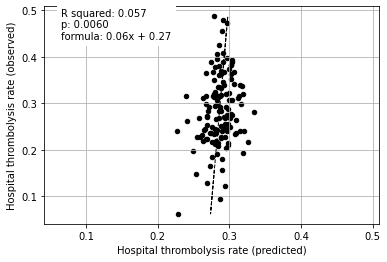

In [39]:
title = "SHAP interactions outside for"
df = df_hosp_mean_shap_interactions_outside

print("Regression between hosptial IVT rate and it's patients mean patient "
      "feature value")
plot_regressions(df, patient_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "patient feature values")
fit_and_plot_multiple_regression(df, patient_features)
plt.show()
print ()

print("Regression between hosptial IVT rate and it's patients mean hospital "
      "feature value")
plot_regressions(df, hospital_features, title)
print ()

print("Multiple regression between hosptial IVT rate and it's patients mean "
      "hospital feature values")
fit_and_plot_multiple_regression(df, hospital_features)
plt.show()

### Create plot for paper

Plot fit from regressions vs IVT rate per hospital for 1) p_main & p_interactions 2) h_main & h_interactions 3) p_main & p_interactions & h_main & h_interactions 


Multiple regression using just patient features
                             coeff
Infarction                0.041541
Stroke severity           0.149400
Precise onset time        0.065744
Prior disability level    0.047780
Use of AF anticoagulants  0.032430
Onset-to-arrival time    -0.275901
Onset during sleep        0.181704
Age                       1.033392

Multiple regression using just hospital features
                         coeff
Arrival-to-scan time  0.078743
Stroke team           0.106717

Multiple regression using hospital and patient features
                             coeff
Arrival-to-scan time      0.057419
Stroke team               0.112744
Infarction                0.037032
Stroke severity           0.088508
Precise onset time        0.133341
Prior disability level    0.095554
Use of AF anticoagulants  0.141731
Onset-to-arrival time    -0.058397
Onset during sleep        0.100957
Age                       0.139023


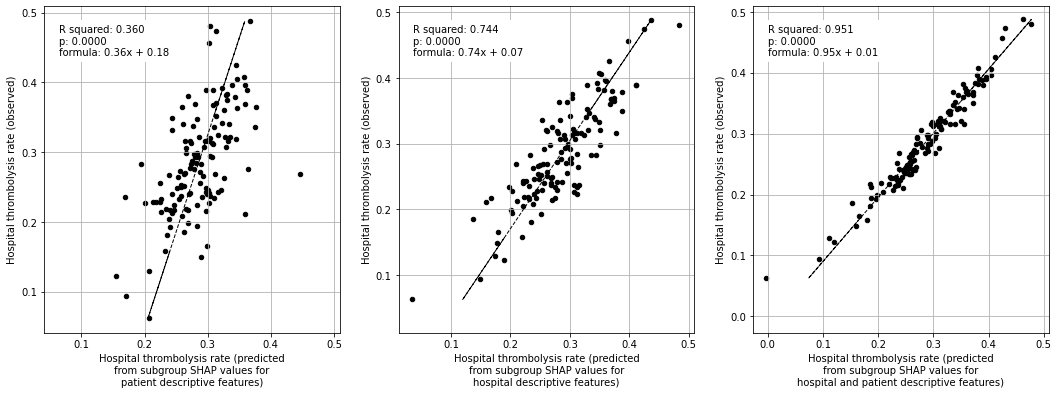

In [40]:
df = df_hosp_mean_shap_main_effects_and_within_interactions

# Create plots with 3 subplots
fig = plt.figure(figsize=(18,6))

print()
print("Multiple regression using just patient features")
ax1 = fig.add_subplot(1,3,1)
# LHS figure of multiple regression with patient contributions
fit_and_plot_multiple_regression(
    df, patient_features, 
    x_label_text = (
        f"\nfrom subgroup SHAP values for\npatient descriptive features"),
    ax=ax1)

print()
print("Multiple regression using just hospital features")
ax2 = fig.add_subplot(1,3,2)
# LHS figure of multiple regression with patient contributions
ax2 = fit_and_plot_multiple_regression(
    df, hospital_features, 
    x_label_text = (
        f"\nfrom subgroup SHAP values for\nhospital descriptive features"),
    ax=ax2)

print()
print("Multiple regression using hospital and patient features")
ax3 = fig.add_subplot(1,3,3)
# LHS figure of multiple regression with patient contributions
ax3 = fit_and_plot_multiple_regression(
    df, (hospital_features + patient_features), 
    x_label_text = (
        f"\nfrom subgroup SHAP values for\nhospital and patient descriptive "
        f"features"),
    ax=ax3)

# Save figure
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_multiple_regression_patient_hosptial.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

# Groupings

What proportion of the SHAP value comes from the main effect and the interactions. This can be calculated in various ways, depending on if you take the sum of the absolute, or the absolute of the sum.

1. Take the sum of the absulute interactions
sum(|main|) + sum(|interaction|)

2. Take the absolute of the sum of the interaction 
|sum(main) + sum(interaction)|

Repeat what did for https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/12a_xgb_shap_interactions.html here, separating out the histogram into two groups (for Patient and for Hospital)

Get data for the three groups. All as individual absolute values

Looking at magnitude of contribution from each element (be it main effect or interaction).

In [41]:
# for patient features
total_of_abs_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features]).sum(axis=(1)))
total_of_abs_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features]).sum(axis=(1)))
# sum patient contributions
total_of_abs_p_contributions_per_instance = (total_of_abs_p_main_per_instance + 
                                total_of_abs_p_interaction_per_instance)

# proportion of patient contributions from interactions
total_of_abs_p_interactions_proportion_per_instance = (
        total_of_abs_p_interaction_per_instance/total_of_abs_p_contributions_per_instance)

# for patient features
total_of_abs_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features]).sum(axis=(1)))
total_of_abs_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features]).sum(axis=(1)))
# sum hosptial contributions
total_of_abs_h_contributions_per_instance = (total_of_abs_h_main_per_instance + 
                                total_of_abs_h_interaction_per_instance)
# proportion of hospital contributions from interactions
total_of_abs_h_interactions_proportion_per_instance = (
                                total_of_abs_h_interaction_per_instance/
                                total_of_abs_h_contributions_per_instance)

# for hospital-patient features
total_of_abs_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside).sum(axis=(1)))

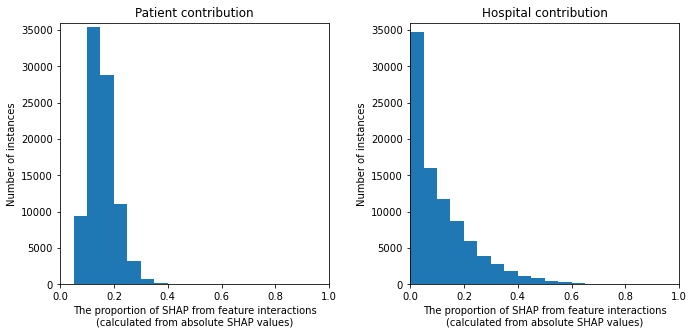

In [42]:
# plot the proportion from interactions as histogram
bins = np.arange(0,1,0.05)

fig = plt.figure(figsize=(10,5))

# Plot patient contribution
ax1 = fig.add_subplot(121)
ax1.hist(total_of_abs_p_interactions_proportion_per_instance, bins=bins);
ax1.set_title("Patient contribution")
ax1.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax1.set_ylabel("Number of instances")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 36000)

# Plot hospital contribution
ax2 = fig.add_subplot(122)
ax2.hist(total_of_abs_h_interactions_proportion_per_instance, bins=bins);
ax2.set_title("Hospital contribution")
ax2.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax2.set_ylabel("Number of instances")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 36000)

plt.tight_layout(pad=2)

plt.show()

For hosptial contributions, the 1 stands for all from interactions, and 0 from main effect. So for majority of patients all hosptial contributions comes from main effect (either hosptial attended, or arrival to scan).

Main effect also dominant for the patient contribution, but to a lesser extent than seen for the hosptial contribution.

In [43]:
print (f"Sum of absolute contributions from patient features: "
       f"{round(total_of_abs_p_contributions_per_instance.sum(),0)}")
print (f"Sum of absolute contributions from hospital features: "
       f"{round(total_of_abs_h_contributions_per_instance.sum(),0)}")
print (f"Sum of absolute contributions from patient-hospital interactions: "
       f"{round(total_of_abs_hpph_contributions_per_instance.sum(),0)}")
print("Sum of the individual absolute log odds")

Sum of absolute contributions from patient features: 444218.0
Sum of absolute contributions from hospital features: 139988.0
Sum of absolute contributions from patient-hospital interactions: 88098.0
Sum of the individual absolute log odds


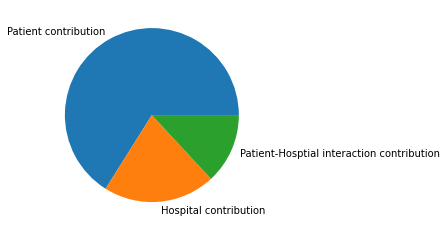

In [44]:
y = np.array([total_of_abs_p_contributions_per_instance.sum(), 
              total_of_abs_h_contributions_per_instance.sum(), 
              total_of_abs_hpph_contributions_per_instance.sum()])
mylabels = ["Patient contribution", "Hospital contribution", 
            "Patient-Hosptial interaction contribution"]
plt.pie(y, labels = mylabels);

Repeat and get data for the three groups all as absolute values of the raw sum.

In [45]:
# for patient features
abs_of_total_p_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[patient_features].sum(axis=(1))))
abs_of_total_p_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[patient_features].sum(axis=(1))))
# sum patient contributions
abs_of_total_p_contributions_per_instance = (abs_of_total_p_main_per_instance + 
                                abs_of_total_p_interaction_per_instance)

# proportion of patient contributions from interactions
abs_of_total_p_interactions_proportion_per_instance = (
                abs_of_total_p_interaction_per_instance/
                abs_of_total_p_contributions_per_instance)

# for patient features
abs_of_total_h_main_per_instance = (np.abs(
            df_hosp_shap_main_effects[hospital_features].sum(axis=(1))))
abs_of_total_h_interaction_per_instance = (np.abs(
            df_hosp_shap_interactions_within[hospital_features].sum(axis=(1))))
# sum hosptial contributions
abs_of_total_h_contributions_per_instance = (abs_of_total_h_main_per_instance + 
                                abs_of_total_h_interaction_per_instance)
# proportion of hospital contributions from interactions
abs_of_total_h_interactions_proportion_per_instance = (
                                abs_of_total_h_interaction_per_instance/
                                abs_of_total_h_contributions_per_instance)

# for hospital-patient features
abs_of_total_hpph_contributions_per_instance = (
                        np.abs(df_hosp_shap_interactions_outside.sum(axis=(1))))

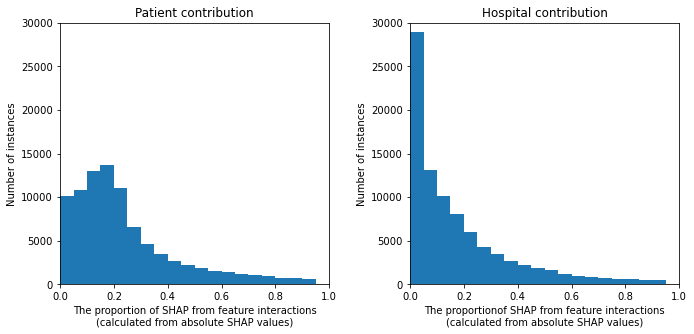

In [46]:
# plot the proportion from interactions as histogram
bins = np.arange(0,1,0.05)
fig = plt.figure(figsize=(10,5))

# Plot patient contribution
ax1 = fig.add_subplot(121)
ax1.hist(abs_of_total_p_interactions_proportion_per_instance, bins=bins);
ax1.set_title("Patient contribution")
ax1.set_xlabel("The proportion of SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax1.set_ylabel("Number of instances")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 30000)

# Plot hospital contribution
ax2 = fig.add_subplot(122)
ax2.hist(abs_of_total_h_interactions_proportion_per_instance, bins=bins);
ax2.set_title("Hospital contribution")
ax2.set_xlabel("The proportionof SHAP from feature interactions\n"
           "(calculated from absolute SHAP values)")
ax2.set_ylabel("Number of instances")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 30000)

plt.tight_layout(pad=2)

plt.show()

In [47]:
print (f"Absolute of sum of contributions from patient features: "
       f"{round(abs_of_total_p_contributions_per_instance.sum(),0)}")
print (f"Absolute of sum of contributions from hospital features: "
       f"{round(abs_of_total_h_contributions_per_instance.sum(),0)}")
print (f"Absolute of sum of contributions from patient-hospital interactions: "
       f"{round(abs_of_total_hpph_contributions_per_instance.sum(),0)}")

Absolute of sum of contributions from patient features: 263261.0
Absolute of sum of contributions from hospital features: 114377.0
Absolute of sum of contributions from patient-hospital interactions: 54049.0


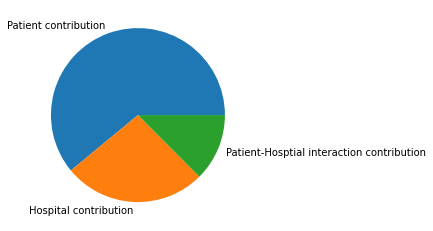

In [48]:
y = np.array([abs_of_total_p_contributions_per_instance.sum(), 
              abs_of_total_h_contributions_per_instance.sum(), 
              abs_of_total_hpph_contributions_per_instance.sum()])
mylabels = ["Patient contribution", "Hospital contribution", 
            "Patient-Hosptial interaction contribution"]
plt.pie(y, labels = mylabels);

Create a table with a row per patient and record the patient SHAP value with three other columns: sum P contributions, sum h contributions, sum hpph contribution (all raw values, not absolute).

Save to a file so MA can check if correlated with embedding-NN output.

In [49]:
# for patient features
total_p_main_per_instance = (
            df_hosp_shap_main_effects[patient_features].sum(axis=(1)))
total_p_interaction_per_instance = (
            df_hosp_shap_interactions_within[patient_features].sum(axis=(1)))
# sum patient contributions
total_p_contributions_per_instance = (total_p_main_per_instance + 
                                      total_p_interaction_per_instance)

# proportion of patient contributions from interactions
total_p_interactions_proportion_per_instance = (
        total_p_interaction_per_instance/total_p_contributions_per_instance)

# for patient features
total_h_main_per_instance = (
            df_hosp_shap_main_effects[hospital_features].sum(axis=(1)))
total_h_interaction_per_instance = (
            df_hosp_shap_interactions_within[hospital_features]).sum(axis=(1))
# sum hosptial contributions
total_h_contributions_per_instance = (total_h_main_per_instance + 
                                      total_h_interaction_per_instance)
# proportion of hospital contributions from interactions
total_h_interactions_proportion_per_instance = (
        total_h_interaction_per_instance/total_h_contributions_per_instance)

# for hospital-patient features
total_hpph_contributions_per_instance = (
                            df_hosp_shap_interactions_outside.sum(axis=(1)))

total_shap_value_per_instance = shap_values_extended.values.sum(axis=(1))
total_unattended_h_per_instance = (total_shap_value_per_instance - 
                                   (total_p_contributions_per_instance +
                                    total_h_contributions_per_instance +
                                    total_hpph_contributions_per_instance))


In [50]:
columns = ["sum_p_contributions", "sum_h_contributions",
           "sum_hpph_contributions", "sum_h_unattended_contributions",
           "total_shap_value"]

df_shap = np.vstack((total_p_contributions_per_instance, 
                     total_h_contributions_per_instance, 
                     total_hpph_contributions_per_instance,
                     total_unattended_h_per_instance,
                     total_shap_value_per_instance,
                     )).T

df_to_file = pd.DataFrame(data=df_shap, 
                          columns=columns)

df_to_file.to_csv(f'./output/{notebook}_{model_text}'
                  f'_shap_p_h_hpph_contributions.csv', )